# Introduction to Echo State Network

@[Chaoming Wang](mailto:adaduo@outlook.com)

In [1]:
import brainpy as bp
import brainpy.math as bm

# enable x64 computation
bm.set_environment(x64=True, mode=bm.batching_mode)
# bm.set_platform('cpu')

bp.__version__

'2.3.1'

In [2]:
import brainpy_datasets as bd
bd.__version__

'0.0.0.2'

In [36]:
import matplotlib.pyplot as plt

## Echo State Network

Echo State Networks (ESNs) are applied to supervised temporal machine learning tasks where for a given training input signal $x(n)$ a desired target output signal $y^{target}(n)$ is known. Here $n=1, ..., T$ is the discrete time and  $T$ is the number of data points in the training dataset.

The task is to learn a model with output $y(n)$, where $y(n)$ matches $y^{target}(n)$ as well as possible, minimizing an error measure $E(y, y^{target})$, and, more importantly, generalizes well to unseen data.

ESNs use an RNN type with leaky-integrated discrete-time continuous-value units. The typical update equations are

$$
\hat{h}(n) = \tanh(W^{in} x(n) + W^{rec}h(n-1) + W^{fb}y(n-1) + b^{rec}) \\
h(n) = (1 - \alpha) x(n-1)+\alpha \hat{h}(n)
$$

where $h(n)$ is a vector of reservoir neuron activations, $W^{in}$ and $W^{rec}$ are the input and recurrent weight matrices respectively, and $\alpha \in (0, 1]$ is the leaking rate. The model is also sometimes used without the leaky integration, which is a special case of $\alpha=1$.

The linear readout layer is defined as

$$
y(n) = W^{out} h(n) + b^{out}
$$

where $y(n)$ is network output, $W^{out}$ the output weight matrix, and $b^{out}$ is the output bias.

An additional nonlinearity can be applied to $y(n)$, as well as feedback connections $W^{fb}$ from $y(n-1)$ to $\hat{h}(n)$.

A graphical representation of an ESN illustrating our notation and the idea for training is depicted in the following figure.

![echo state machine](../_static/echo_state_net.png)

## Ridge regression

Finding the optimal weights $W^{out}$ that minimize the squared error between $y(n)$ and $y^{target}(n)$ amounts to solving a typically overdetermined system of linear equations

$$Y^{target} = W^{out}X$$

Probably the most universal and stable solution is ridge regression, also known as regression with Tikhonov regularization:

$$W^{out} = Y^{target}X^T(XX^T+\beta I)^{-1}$$

## Dataset

Mackey-Glass equation are a set of delayed differential equations describing the temporal behaviour of different physiological signal, for example, the relative quantity of mature blood cells over time.

The equations are defined as:

$$ \frac{dP(t)}{dt} = \frac{\beta P(t - \tau)}{1 + P(t - \tau)^n} - \gamma P(t) $$

where $\beta = 0.2$, $\gamma = 0.1$, $n = 10$, and the time delay $\tau = 17$. $\tau$ controls the chaotic behaviour of the equations (the higher it is, the more chaotic the timeserie becomes. $\tau=17$ already gives good chaotic results.)

In [37]:
def plot_mackey_glass_series(ts, x_series, x_tau_series, num_sample):
  plt.figure(figsize=(13, 5))

  plt.subplot(121)
  plt.title(f"Timeserie - {num_sample} timesteps")
  plt.plot(ts[:num_sample], x_series[:num_sample], lw=2, color="lightgrey", zorder=0)
  plt.scatter(ts[:num_sample], x_series[:num_sample], c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$t$")
  plt.ylabel("$P(t)$")

  ax = plt.subplot(122)
  ax.margins(0.05)
  plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
  plt.plot(x_tau_series[: num_sample], x_series[: num_sample], lw=1, color="lightgrey", zorder=0)
  plt.scatter(x_tau_series[:num_sample], x_series[: num_sample], lw=0.5, c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$P(t-\\tau)$")
  plt.ylabel("$P(t)$")
  cbar = plt.colorbar()
  cbar.ax.set_ylabel('$t$')

  plt.tight_layout()
  plt.show()

An easy way to get Mackey-Glass time-series data is using ``brainpy.dataset.mackey_glass_series()``. If you want to see the details of the implementation, please see the corresponding source code.

In [38]:
dt = 0.1
mg_data = bd.chaos.MackeyGlassEq(25000, dt=dt, tau=17, beta=0.2, gamma=0.1, n=10)
ts = mg_data.ts
xs = mg_data.xs
ys = mg_data.ys

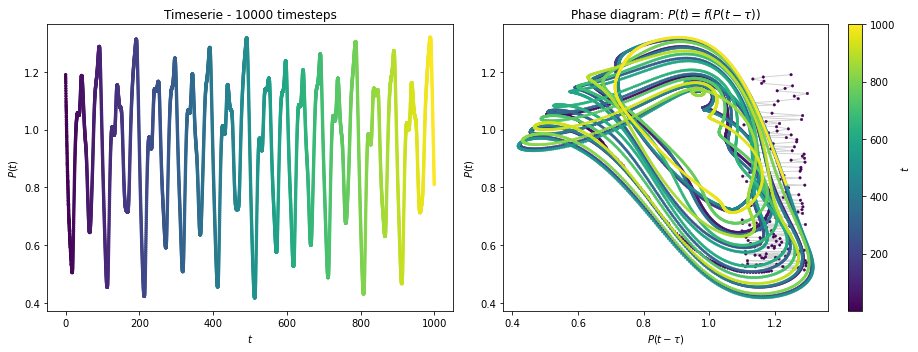

In [39]:
plot_mackey_glass_series(ts, xs, ys, num_sample=int(1000 / dt))

## Task 1: prediction of Mackey-Glass timeseries

Predict $P(t+1), \cdots, P(t+N)$ from $P(t)$.

### Prepare the data

In [40]:
def get_data(t_warm, t_forcast, t_train, sample_rate=1):
    warmup = int(t_warm / dt)  # warmup the reservoir
    forecast = int(t_forcast / dt)  # predict 10 ms ahead
    train_length = int(t_train / dt)

    X_warm = xs[:warmup:sample_rate]
    X_warm = bm.expand_dims(X_warm, 0)

    X_train = xs[warmup: warmup+train_length: sample_rate]
    X_train = bm.expand_dims(X_train, 0)

    Y_train = xs[warmup+forecast: warmup+train_length+forecast: sample_rate]
    Y_train = bm.expand_dims(Y_train, 0)

    X_test = xs[warmup + train_length: -forecast: sample_rate]
    X_test = bm.expand_dims(X_test, 0)

    Y_test = xs[warmup + train_length + forecast::sample_rate]
    Y_test = bm.expand_dims(Y_test, 0)

    return X_warm, X_train, Y_train, X_test, Y_test

In [41]:
# First warmup the reservoir using the first 100 ms
# Then, train the network in 20000 ms to predict 1 ms chaotic series ahead
x_warm, x_train, y_train, x_test, y_test = get_data(100, 1, 20000)

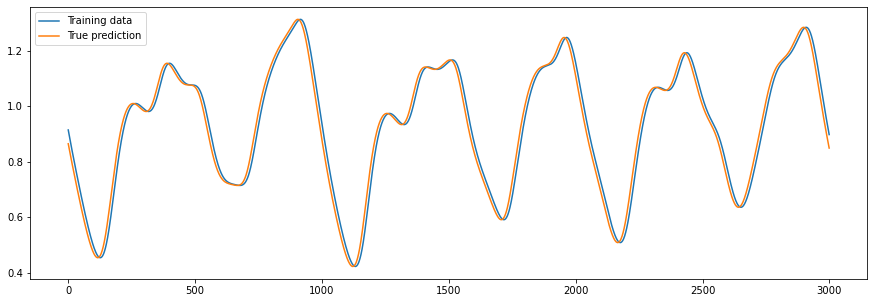

In [42]:
sample = 3000
fig = plt.figure(figsize=(15, 5))
plt.plot(x_train[0, :sample], label="Training data")
plt.plot(y_train[0, :sample], label="True prediction")
plt.legend()
plt.show()

### Prepare the ESN

In [43]:
class ESN(bp.dyn.DynamicalSystem):
  def __init__(self, num_in, num_hidden, num_out, sr=1., leaky_rate=0.3,
               Win_initializer=bp.init.Uniform(0, 0.2)):
    super(ESN, self).__init__()
    self.r = bp.layers.Reservoir(
        num_in, num_hidden,
        Win_initializer=Win_initializer,
        spectral_radius=sr,
        leaky_rate=leaky_rate,
    )
    self.o = bp.layers.Dense(num_hidden, num_out, mode=bm.training_mode)

  def update(self, sha, x):
    return self.o(sha, self.r(sha, x))

### Train and test ESN

In [44]:
model = ESN(1, 100, 1)
model.reset_state(1)
trainer = bp.train.RidgeTrainer(model, alpha=1e-6)

In [45]:
# warmup
_ = trainer.predict(x_warm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [46]:
# train
_ = trainer.fit([x_train, y_train])

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Test the training data.

In [47]:
ys_predict = trainer.predict(x_train)

  0%|          | 0/200000 [00:00<?, ?it/s]

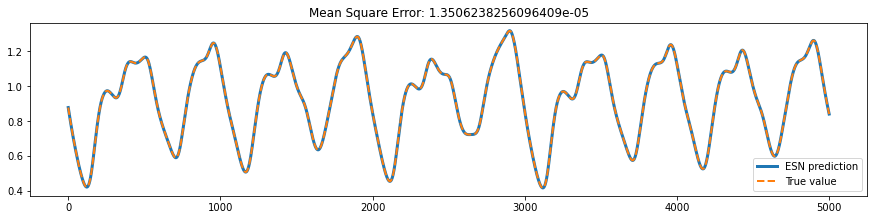

In [48]:
start, end = 1000, 6000
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.as_numpy(ys_predict)[0, start:end, 0],
         lw=3, label="ESN prediction")
plt.plot(bm.as_numpy(y_train)[0, start:end, 0], linestyle="--",
         lw=2, label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(ys_predict, y_train)}')
plt.legend()
plt.show()

Test the testing data.

  0%|          | 0/48990 [00:00<?, ?it/s]

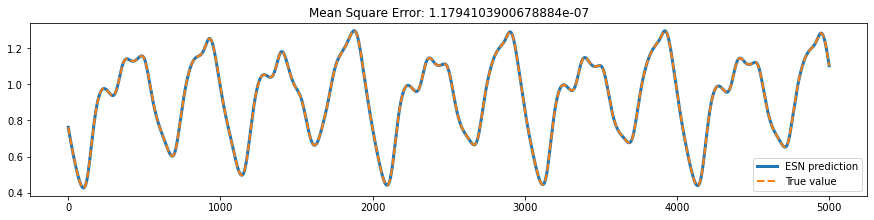

In [49]:
ys_predict = trainer.predict(x_test)

start, end = 1000, 6000
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.as_numpy(ys_predict)[0, start:end, 0], lw=3, label="ESN prediction")
plt.plot(bm.as_numpy(y_test)[0,start:end, 0], linestyle="--", lw=2, label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(ys_predict, y_test)}')
plt.legend()
plt.show()

### Make the task harder

In [50]:
# First warmup the reservoir using the first 100 ms
# Then, train the network in 20000 ms to predict 10 ms chaotic series ahead
x_warm, x_train, y_train, x_test, y_test = get_data(100, 10, 20000)

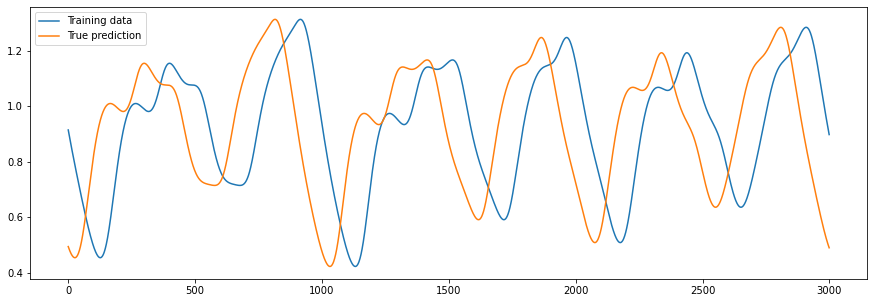

In [51]:
sample = 3000
plt.figure(figsize=(15, 5))
plt.plot(x_train[0, :sample], label="Training data")
plt.plot(y_train[0, :sample], label="True prediction")
plt.legend()
plt.show()

In [52]:
model = ESN(1, 100, 1, sr=1.1)
model.reset_state(1)
trainer = bp.train.RidgeTrainer(model, alpha=1e-6)

In [53]:
# warmup
_ = trainer.predict(x_warm)

# train
_ = trainer.fit([x_train, y_train])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/48900 [00:00<?, ?it/s]

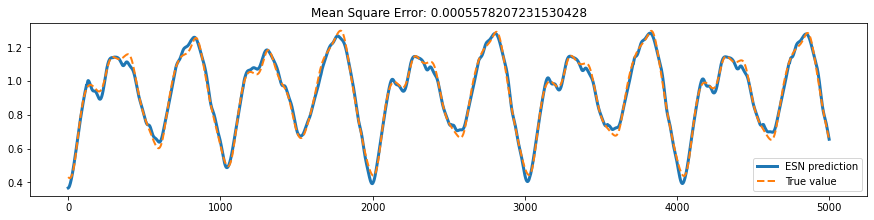

In [54]:
ys_predict = trainer.predict(x_test, )

start, end = 1000, 6000
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.as_numpy(ys_predict)[0, start:end, 0], lw=3, label="ESN prediction")
plt.plot(bm.as_numpy(y_test)[0, start:end, 0], linestyle="--", lw=2, label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(ys_predict, y_test)}')
plt.legend()
plt.show()

### Diving into the reservoir

Let's have a look at the effect of some of the hyperparameters of the ESN.

#### Spectral radius

The spectral radius is defined as the maximum eigenvalue of the reservoir matrix.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

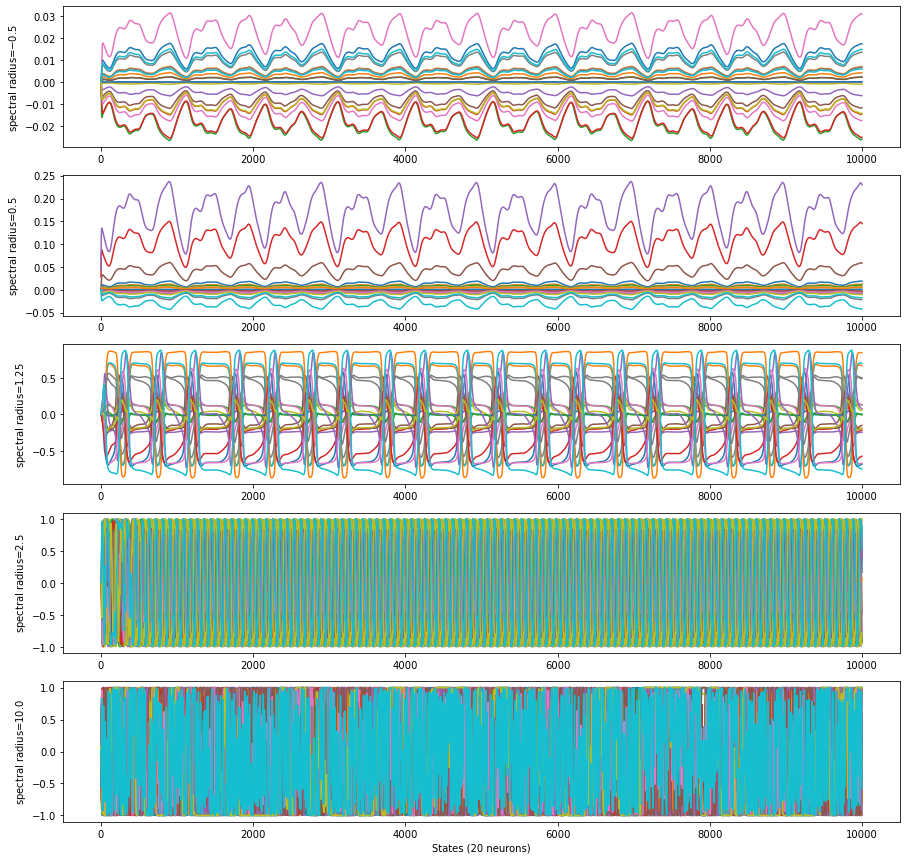

In [55]:
num_sample = 20
all_radius = [-0.5, 0.5, 1.25, 2.5, 10.]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_radius):
  model = ESN(1, 100, 1, sr=s)
  model.reset_state(1)
  runner = bp.train.DSTrainer(model, monitors={'state': model.r.state})
  _ = runner.predict(x_test[:, :10000])
  states = bm.as_numpy(runner.mon['state'])

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[0, :, :num_sample])
  plt.ylabel(f"spectral radius=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()


- spectral radius < 1 $\rightarrow$ **stable** dynamics

- spectral radius > 1 $\rightarrow$ **chaotic** dynamics

In most cases, it should have a value around $1.0$ to ensure the *echo state property* (ESP): the dynamics of the reservoir should not be bound to the initial state chosen, and remains close to chaos.

This value also heavily depends on the input scaling.


#### Input scaling

The input scaling controls how the ESN interact with the inputs. It is a coefficient appliyed to the input matrix $W^{in}$.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

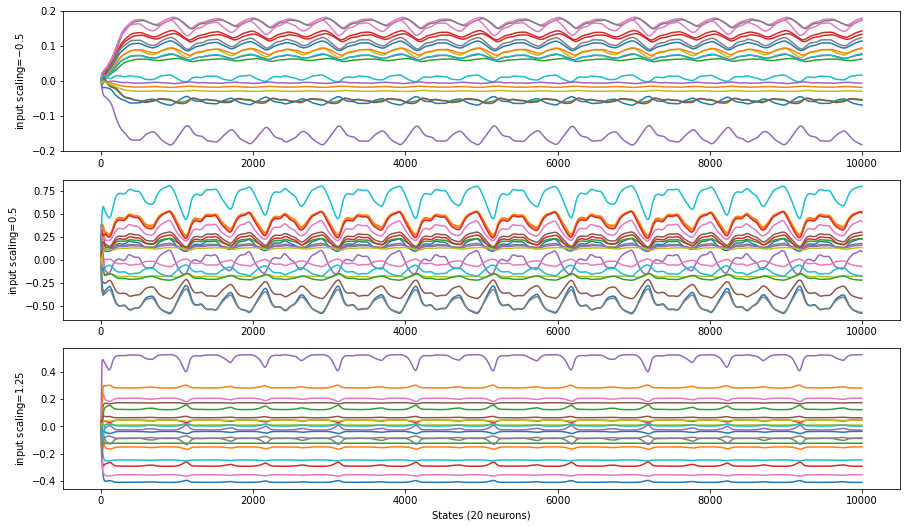

In [56]:
num_sample = 20
all_input_scaling = [0.1, 1.0, 10.0]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_input_scaling):
  model = ESN(1, 100, 1, sr=1., Win_initializer=bp.init.Uniform(max_val=s))
  model.reset_state(1)
  runner = bp.train.DSTrainer(model, monitors={'state': model.r.state})
  _ = runner.predict(x_test[:, :10000])
  states = bm.as_numpy(runner.mon['state'])

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[0, :, :num_sample])
  plt.ylabel(f"input scaling=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

#### Leaking rate

The leaking rate ($\alpha$) controls the "memory feedback" of the ESN. The ESN states are indeed computed as:

$$
h(t+1) =  \underbrace{\color{red}{(1 - \alpha)} h(t)}_{\text{previous states}} + \underbrace{\color{red}\alpha f(x(t+1), h(t))}_{\text{new states}}
$$

where $h$ is the state, $x$ is the input data, $f$ is the ESN model function, defined as:

$$ f(x, h) = \tanh(W^{in} \cdotp x + W^{rec} \cdotp h) $$

$\alpha$ must be in $[0, 1]$.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

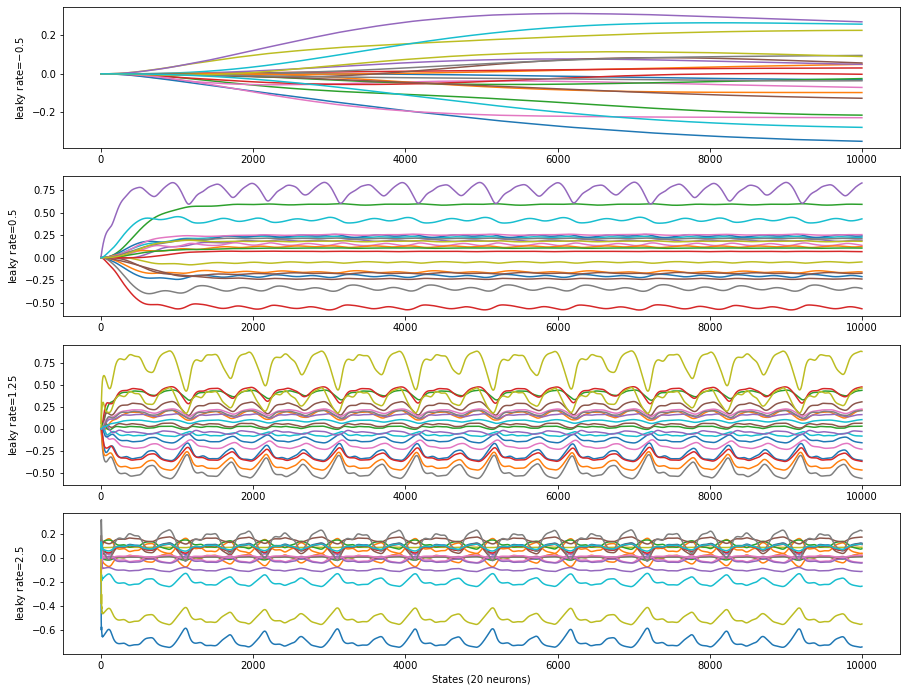

In [57]:
num_sample = 20
all_rates = [0.001, 0.01, 0.1, 1.]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_rates):
  model = ESN(1, 100, 1, sr=1., leaky_rate=s,
              Win_initializer=bp.init.Uniform(max_val=1.), )
  model.reset_state(1)
  runner = bp.train.DSTrainer(model, monitors={'state': model.r.state})
  _ = runner.predict(x_test[:, :10000])
  states = bm.as_numpy(runner.mon['state'])

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[0, :, :num_sample])
  plt.ylabel(f"leaky rate=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

Let's reduce the input influence to see what is happening inside the reservoir (input scaling set to 0.2):

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

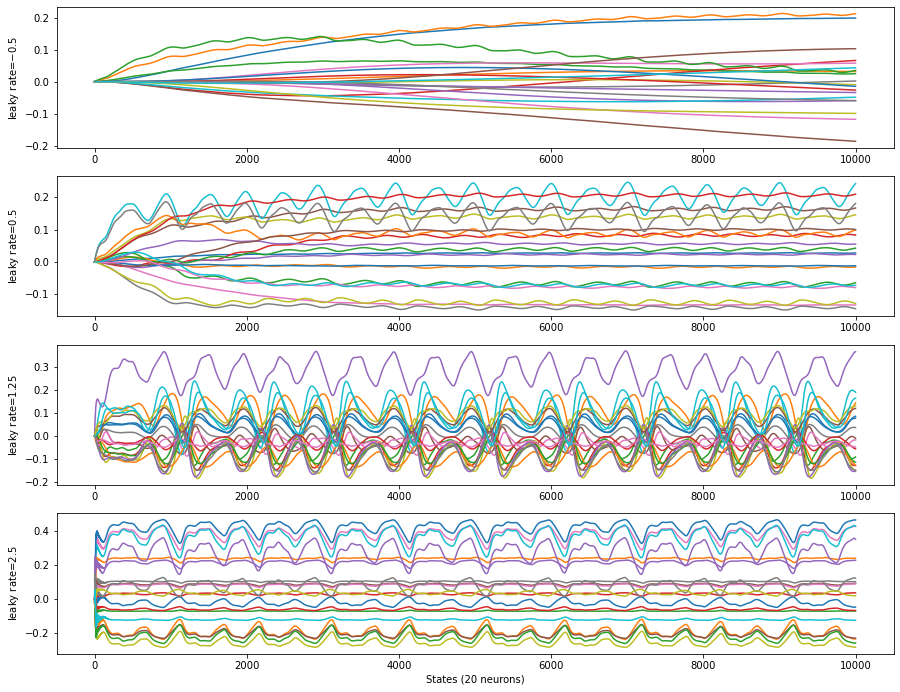

In [58]:
num_sample = 20
all_rates = [0.001, 0.01, 0.1, 1.]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_rates):
  model = ESN(1, 100, 1, sr=1., leaky_rate=s,
              Win_initializer=bp.init.Uniform(max_val=.2), )
  model.reset_state(1)
  runner = bp.train.DSTrainer(model, monitors={'state': model.r.state})
  _ = runner.predict(x_test[:, :10000])
  states = bm.as_numpy(runner.mon['state'])

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[0, :, :num_sample])
  plt.ylabel(f"leaky rate=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

- high leaking rate $\rightarrow$ **low inertia**, little memory of previous states
- low leaking rate $\rightarrow$ **high inertia**, big memory of previous states

The leaking rate can be seen as the inverse of the reservoir's time contant.


## Task 2: generation of Mackey-Glass timeseries

Generative mode: the output of ESN will be used as the input. 

During this task, the ESN is trained to make a short forecast of the timeserie (1 timestep ahead). Then, it will be asked to run on its own outputs, trying to predict its own behaviour.

In [59]:
# First warmup the reservoir using the first 500 ms
# Then, train the network in 20000 ms to predict 1 ms chaotic series ahead
x_warm, x_train, y_train, x_test, y_test = get_data(500, 1, 20000, sample_rate=int(1/dt))

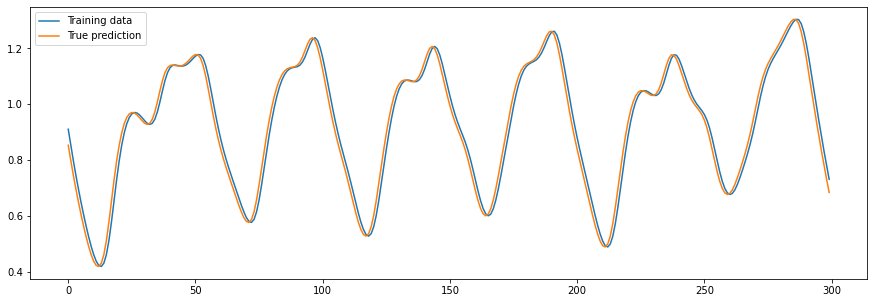

In [60]:
sample = 300
fig = plt.figure(figsize=(15, 5))
plt.plot(x_train[0, :sample], label="Training data")
plt.plot(y_train[0, :sample], label="True prediction")
plt.legend()
plt.show()

In [61]:
model = ESN(1, 100, 1, sr=1.1, Win_initializer=bp.init.Uniform(max_val=.2), )
model.reset_state(1)
trainer = bp.train.RidgeTrainer(model, alpha=1e-7)

In [62]:
# warmup
_ = trainer.predict(x_warm)

# train
trainer.fit([x_train, y_train])

# test
ys_predict = trainer.predict(x_train)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

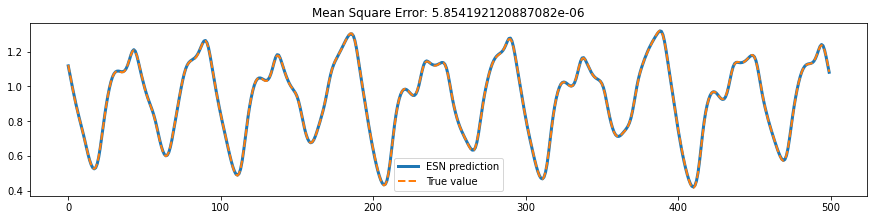

In [63]:
start, end = 100, 600
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.as_numpy(ys_predict)[0, start:end, 0],
         lw=3, label="ESN prediction")
plt.plot(bm.as_numpy(y_train)[0, start:end, 0], linestyle="--",
         lw=2, label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(ys_predict, y_train)}')
plt.legend()
plt.show()

In [64]:
jit_model = bm.jit(model)

In [65]:
outputs = [x_test[:, 0]]
truths = [x_test[:, 1]]
for i in range(200):
    outputs.append(jit_model(dict(), outputs[-1]))
    truths.append(x_test[:, i+2])
outputs = bm.asarray(outputs)
truths = bm.asarray(truths)

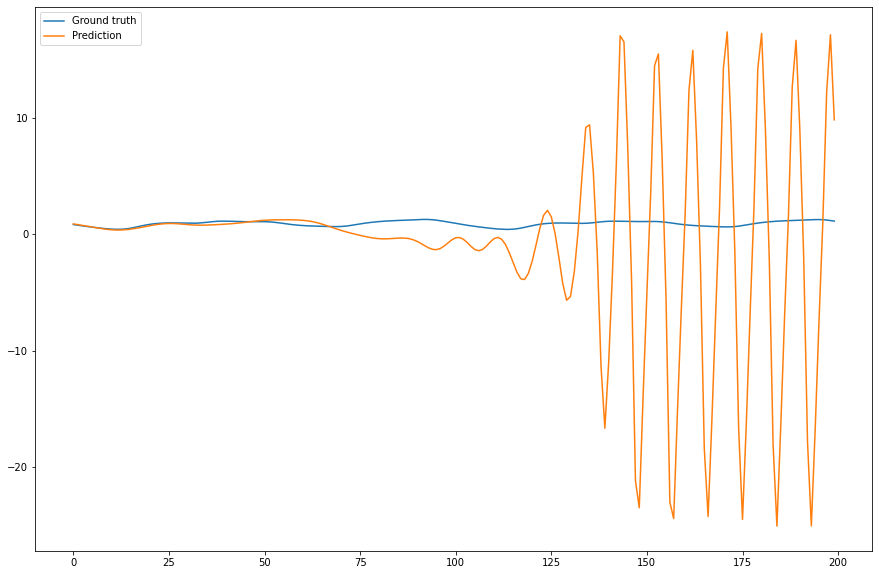

In [66]:
plt.figure(figsize=(15, 10))
plt.plot(bm.as_numpy(truths).squeeze()[:200], label='Ground truth')
plt.plot(bm.as_numpy(outputs).squeeze()[:200], label='Prediction')
plt.legend()
plt.show()

## References

- Jaeger, H.: The “echo state” approach to analysing and training recurrent neural
  networks. Technical Report GMD Report 148, German National Research Center
  for Information Technology (2001)
- Lukoševičius, Mantas. “A Practical Guide to Applying Echo State Networks.” Neural Networks: Tricks of the Trade (2012).